# Intercomparison

**Author:** Hannah Kerner, Ivan Zvonkov

**Last updated:** January 26, 2024

**Description:** Runs intercomparison for Rwanda 2019

## 1. Setup

In [1]:
#earthengine authenticate

In [2]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd

ee.Initialize()

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

## 2. Read in evaluation set

In [3]:
country = "Rwanda"
country_code = TEST_CODE[country]
dataset_path = "../" + TEST_COUNTRIES[country]

In [4]:
df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
df = df[(df["class_probability"] != 0.5)].copy()
# use only test data because validation points used for harvest-dev map
df = df[df["subset"] == "testing"].copy()
df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

/Users/hkerner/anaconda3/envs/landcover-mapping/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


## 3. Run intercomparison

In [5]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [6]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Rwanda] sampling copernicus...
[Rwanda] sampling worldcover-v100...
[Rwanda] sampling worldcover-v200...
[Rwanda] sampling worldcereal-v100...
[Rwanda] sampling glad...
[Rwanda] sampling asap...
[Rwanda] sampling dynamicworld...
[Rwanda] sampling gfsad-gcep...
[Rwanda] sampling gfsad-lgrip...
[Rwanda] sampling digital-earth-africa...
[Rwanda] sampling esa-cci-africa...
[Rwanda] sampling globcover-v23...
[Rwanda] sampling globcover-v22...
[Rwanda] sampling esri-lulc...
[Rwanda] sampling nabil-etal-2021...
[Rwanda] sampling harvest-dev...


In [7]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    a_j[cropmap.title] = cropmap.compute_map_area(country).copy()

[Rwanda] calculating pixel area for copernicus...
[Rwanda] calculating pixel area for worldcover-v100...
[Rwanda] calculating pixel area for worldcover-v200...
[Rwanda] calculating pixel area for worldcereal-v100...
[Rwanda] calculating pixel area for glad...
[Rwanda] calculating pixel area for asap...
[Rwanda] calculating pixel area for dynamicworld...
[Rwanda] calculating pixel area for gfsad-gcep...
[Rwanda] calculating pixel area for gfsad-lgrip...
[Rwanda] calculating pixel area for digital-earth-africa...
[Rwanda] calculating pixel area for esa-cci-africa...
[Rwanda] calculating pixel area for globcover-v23...
[Rwanda] calculating pixel area for globcover-v22...
[Rwanda] calculating pixel area for esri-lulc...
[Rwanda] calculating pixel area for nabil-etal-2021...
[Rwanda] calculating pixel area for harvest-dev...


In [8]:
comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], use_strat=True)
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = ["glad", "worldcover-v200", "esri-lulc"] # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf[ensemble_maps].mode(axis='columns')
a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps])
comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], use_strat=True)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

copernicus
[[70 37]
 [28 64]]
[0.51684244 0.48315756]
worldcover-v100
[[96 11]
 [41 51]]
[0.68090348 0.31909652]
worldcover-v200
[[97 10]
 [43 49]]
[0.68528718 0.31471282]
worldcereal-v100
[[103   4]
 [ 69  23]]
[0.85042395 0.14957605]
glad
[[87 20]
 [46 46]]
[0.6405438 0.3594562]
asap
[[59 48]
 [21 71]]
[0.36919437 0.63080563]
dynamicworld
[[104   3]
 [ 76  16]]
[0.89360482 0.10639518]
gfsad-gcep
[[65 42]
 [28 64]]
[0.4771446 0.5228554]
gfsad-lgrip
[[62 45]
 [29 63]]
[0.47570872 0.52429128]
digital-earth-africa
[[73 34]
 [21 71]]
[0.32693878 0.67306122]
esa-cci-africa
[[71 36]
 [35 57]]
[0.54471277 0.45528723]
globcover-v23
[[59 48]
 [35 57]]
[0.42073188 0.57926812]
globcover-v22
[[63 44]
 [37 55]]
[0.51353867 0.48646133]
esri-lulc
[[100   7]
 [ 55  37]]
[0.74786585 0.25213415]
nabil-etal-2021
[[65 42]
 [28 64]]
[0.4817655 0.5182345]
harvest-dev
[[70 37]
 [21 71]]
[0.45862665 0.54137335]
Ensemble maps: ['glad', 'worldcover-v200', 'esri-lulc']
ensemble-subset
[[101   6]
 [ 44  48]]
[0.

,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,...,crop_support,noncrop_support,tn,fp,fn,tp,tn_area,fp_area,fn_area,tp_area
dataset,,,,,,,,,,,,,,,,,,,,,
copernicus,Rwanda,0.65,0.13,0.68,0.03,0.67,0.04,0.68,0.03,0.63,...,92,107,70,37,28,64,0.37,0.18,0.15,0.31
worldcover-v100,Rwanda,0.67,0.12,0.74,0.03,0.56,0.04,0.89,0.03,0.82,...,92,107,96,11,41,51,0.48,0.06,0.20,0.26
worldcover-v200,Rwanda,0.66,0.12,0.74,0.03,0.55,0.03,0.90,0.03,0.83,...,92,107,97,10,43,49,0.47,0.05,0.21,0.26
worldcereal-v100,Rwanda,0.41,0.11,0.64,0.03,0.27,0.02,0.96,0.02,0.85,...,92,107,103,4,69,23,0.51,0.02,0.34,0.13
glad,Rwanda,0.60,0.14,0.67,0.03,0.53,0.04,0.79,0.03,0.70,...,92,107,87,20,46,46,0.42,0.11,0.22,0.25
asap,Rwanda,0.68,0.12,0.65,0.03,0.80,0.03,0.52,0.03,0.60,...,92,107,59,48,21,71,0.27,0.25,0.10,0.38
dynamicworld,Rwanda,0.31,0.10,0.61,0.03,0.19,0.02,0.97,0.02,0.84,...,92,107,104,3,76,16,0.52,0.02,0.38,0.09
gfsad-gcep,Rwanda,0.64,0.13,0.65,0.03,0.69,0.04,0.62,0.03,0.60,...,92,107,65,42,28,64,0.33,0.21,0.14,0.32
gfsad-lgrip,Rwanda,0.62,0.13,0.63,0.03,0.67,0.04,0.60,0.03,0.58,...,92,107,62,45,29,63,0.32,0.22,0.15,0.31


In [11]:
results.to_csv('/Users/hkerner/Downloads/rwanda-metrics-area-weighted-fixed.csv')

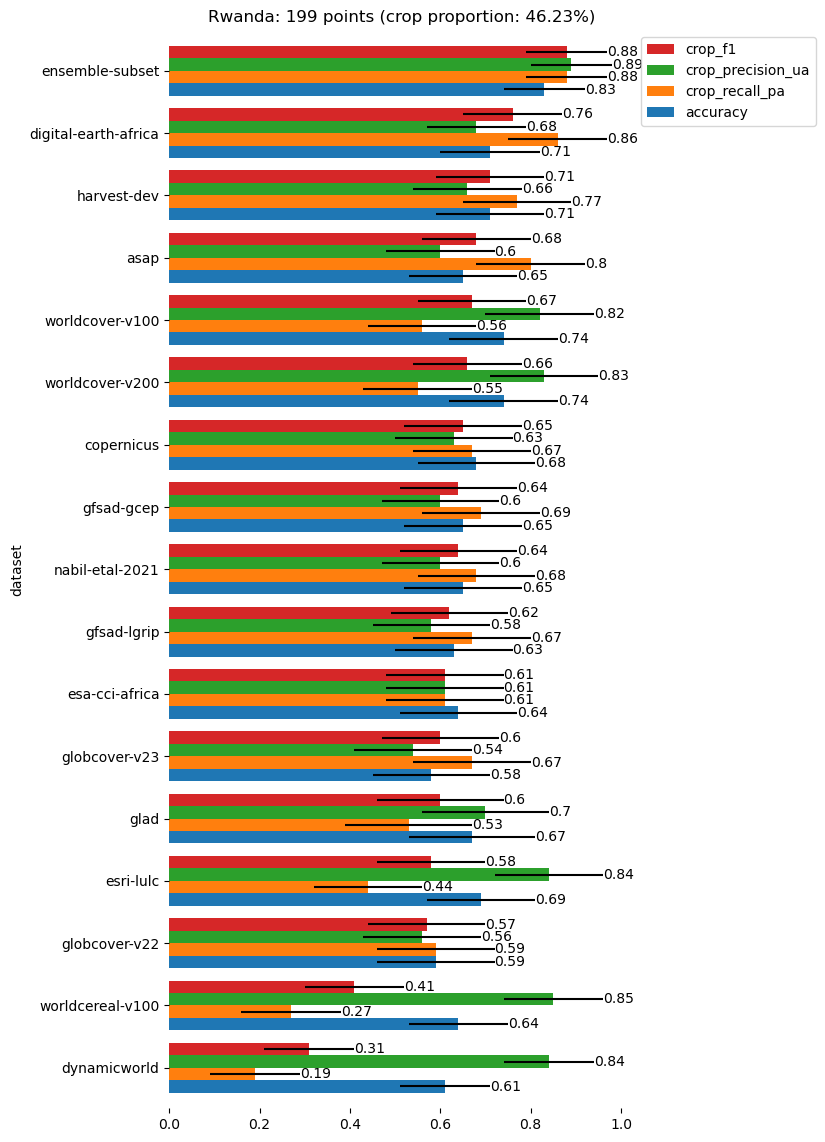

In [9]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

## 4. Visualize best available map

In [10]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
best_dataset = results["crop_f1"].idxmax()
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

To view and export map copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0")
    .filter(ee.Filter.eq('ADM0_NAME', 'Rwanda'));
Map.centerObject(aoi, 7);

var glad = ee.ImageCollection("users/potapovpeter/Global_cropland_2019").filterBounds(aoi).mosaic().clip(aoi);
glad = glad.gte(0.5).rename('crop')
Map.addLayer(glad, classVis, 'Cropland from glad');


var worldcover_v200 = ee.ImageCollection("ESA/WorldCover/v200").filterBounds(aoi).mosaic().clip(aoi);
worldcover_v200 = worldcover_v200.eq(40).rename('crop')
Map.addLayer(worldcover_v200, classVis, 'Cropland from worldcover-v200');


var esri_lulc = ee.ImageCollection(
            "projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS"
        ).filter(ee